# <mark>PyTorch:</mark> Stochastic-Gradient-Aggregation Dataset Imagewoof

In [1]:
# PyTorch Utils
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import DataLoader
from torchvision.transforms import v2 as T
from torchvision import datasets
from torch.optim import lr_scheduler

# MatPlot
import matplotlib.pyplot as plt

# NumPy
import numpy as np

# Pandas
import pandas as pd

# Other Utils
import os
import datetime
from PIL import Image

In [2]:
# Debug CUDA information
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1650


In [3]:
# Device usage definition
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Image Processing For Future Display

In [4]:
def process_image(img, transpose=False):
    """
    Preprocess the images to displays them in a plot.

    Parameters:
    - img: The image to preprocess.
    - transpose: Bool value if the img needs to be transposed.

    Returns:
    - img: The image preprocessed.       
    """
    if transpose:
        img = img.numpy().transpose((1, 2, 0)) # Transform (X, Y, Z) shape
    img = (img - img.min()) / (img.max() - img.min()) # Clip the image to [0, 255] values
    return img

### Load Imagewoof Dataset

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 9. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |
| n02096294      | Australian terrier |
| n02099601      | Golden retriever |
| n02105641      | Old English sheepdog |
| n02111889      | Samoyed |
| n02115641      | Dingo |

<br>

In [5]:
# Define the batch size
batch_size = 8

In [6]:
# Define the directory where your dataset is located
data_dir = 'Datasets/Imagewoof'

In [7]:
# Define the transformations you want to apply to the images
data_transforms = {
    'train': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.RandomHorizontalFlip(),
        T.RandomGrayscale(p=0.1),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.CenterCrop(224),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
# Create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [9]:
# Create dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

### Define New Classes With the Correct Dog Breeds

In [10]:
# Correct dog breeds
dog_breeds = [
    'Shih-Tzu', 'Rhodesian Ridgeback', 'Beagle', 'English Foxhound', 'Border Terrier',
    'Australian Terrier', 'Golden Retriever', 'Old English Sheepdog', 'Samoyed', 'Dingo'
]

# Assing the dog breeds to the class names
class_names = dog_breeds

### Iterating and Visualising the Dataset

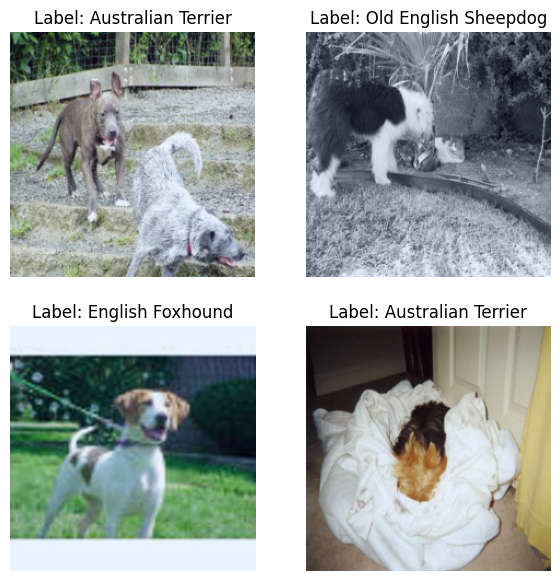

In [76]:
# Get a batch of images and labels
imgs, labels = next(iter(dataloaders['train']))

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for i, ax in enumerate(axes.flat):
    # Convert the tensor to numpy array and transpose the dimensions if necessary
    img_np = imgs[i].numpy().transpose((1, 2, 0)) if isinstance(imgs, torch.Tensor) else imgs[i]
    img_np = process_image(img_np)
    
    ax.imshow(img_np)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.show()

### SGA TESTING

In [134]:
uap = torch.load('./SGA/UAP/SGA/Delta_1000_11_Epochs_8_Batch.pth')

In [137]:
uap

tensor([[[-3.5294e-02, -7.8431e-03, -2.3529e-02,  ..., -3.9216e-02,
          -3.1373e-02, -3.5294e-02],
         [ 3.9216e-03,  2.7451e-02,  1.1765e-02,  ..., -3.1373e-02,
          -3.1373e-02, -3.5294e-02],
         [ 1.9608e-02,  1.1765e-02,  1.1765e-02,  ...,  2.3529e-02,
          -3.1373e-02, -3.5294e-02],
         ...,
         [ 3.1373e-02,  3.1373e-02,  3.9216e-02,  ...,  1.9608e-02,
           2.7940e-09,  2.3529e-02],
         [-1.9608e-02,  3.9216e-02,  1.1765e-02,  ...,  3.9216e-03,
          -3.1373e-02, -3.9216e-02],
         [-3.5294e-02,  3.5294e-02,  3.9216e-02,  ...,  2.7451e-02,
          -1.1765e-02, -3.9216e-03]],

        [[ 3.5294e-02,  3.5294e-02, -1.1765e-02,  ..., -3.5294e-02,
          -2.7940e-09,  3.9216e-02],
         [ 3.9216e-03,  3.9216e-03, -1.5686e-02,  ..., -3.9216e-02,
          -3.9216e-02,  3.9216e-03],
         [ 7.8431e-03,  7.8431e-03, -1.5686e-02,  ..., -3.5294e-02,
          -3.5294e-02, -3.9216e-02],
         ...,
         [-3.9216e-02, -1

In [44]:
# uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

In [93]:
# Load your dataset
imgs, labels = next(iter(dataloaders['val']))

# Convert PyTorch tensor to numpy array if necessary
imgs_np = imgs.numpy()

# Create an empty list to store adversarial images
adversarial_dataset = []

uap = uap.cpu()

# Iterate through the dataset
for img in imgs_np:
    adversarial_img = img + uap.numpy()
    adversarial_dataset.append(adversarial_img)

# Convert the list of adversarial images back to a PyTorch tensor
adversarial_dataset = torch.Tensor(adversarial_dataset)

In [94]:
def preimage(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image

In [95]:
len(adversarial_dataset)

8

In [96]:
len(imgs_np)

8

In [97]:
idx = 0

In [98]:
img_test = adversarial_dataset[0]

In [99]:
img_test.min()

tensor(-2.1493)

In [100]:
imgs_np[0].min()

-2.117904

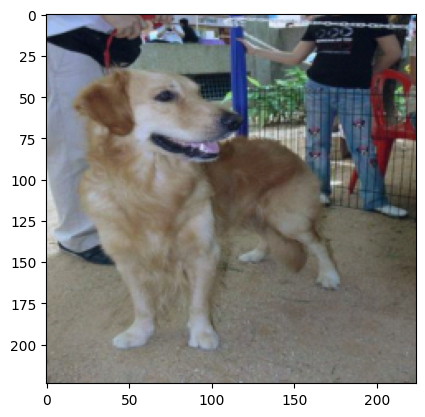

In [101]:
img = adversarial_dataset[idx].numpy().transpose((1, 2, 0))
# img = preimage(adversarial_dataset[idx])
img = preimage(img)
plt.imsave('./Test/SGA-GR.jpg', img)
plt.imshow(img)

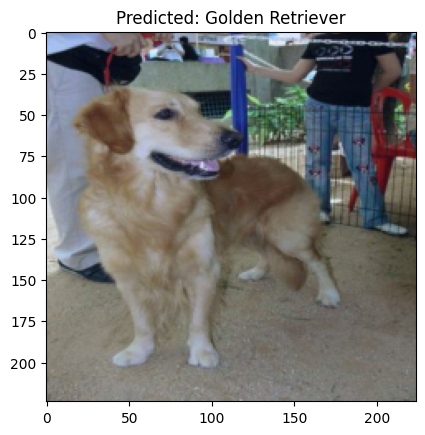

In [102]:
plt.title(f'Predicted: {class_names[labels[idx]]}')
img = process_image(imgs_np[idx].transpose((1, 2, 0)), False)
plt.imshow(img)

### <mark>Load Model!</mark>

In [66]:
model = torch.jit.load('./Models/ModelVGG16.pt') # Load
model.eval()

RecursiveScriptModule(
  original_name=VGG
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=Conv2d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=MaxPool2d)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Conv2d)
    (13): RecursiveScriptModule(original_name=ReLU)
    (14): RecursiveScriptModule(original_name=Conv2d)
    (15): RecursiveScriptModule(original_name=ReLU)
    (16): RecursiveScriptModule(original_name

### Inference on Custom Images

In [67]:
def visualise_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        plt.figsize=(10, 10)
        plt.axis('off')
        plt.title(f'Predicted: {class_names[preds[0]]}')
        img = process_image(img.cpu().data[0], True)
        plt.imshow(img)
        plt.show()

        model.train(mode=was_training)

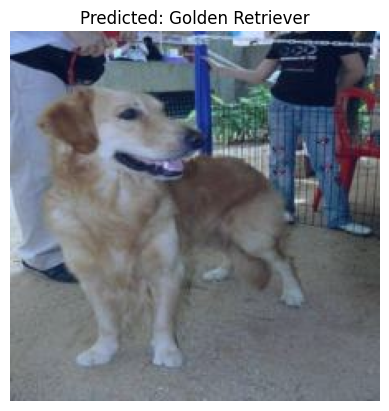

In [103]:
visualise_model_predictions(
    model,
    img_path='./Test/SGA-GR.jpg'
)

In [106]:
uap = torch.load('./SGA/UAP/SGA/Delta_1000_11_Epochs_8_Batch.pth')
uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

probs, labels, y_out = [], [], []

with torch.no_grad():
    for i, data in enumerate(dataloaders['val']):
        x_val = data[0].to(device)
        y_val = data[1].to(device)

        y_ori = torch.nn.functional.softmax(model(x_val), dim = 1)
        perturbed = torch.clamp((x_val + uap), 0, 1) # Clamp to [0, 1]
        out = torch.nn.functional.softmax(model(perturbed), dim = 1)

        probs.append(out.cpu().numpy())
        labels.append(y_val.cpu())
        y_out.append(y_ori.cpu().numpy())

In [126]:
perturbed[0]

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

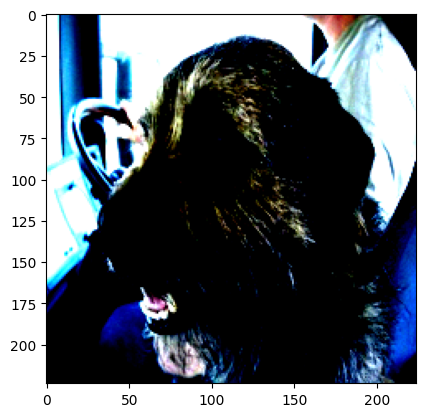

In [132]:
img = process_image(perturbed[0].cpu().numpy().transpose((1, 2, 0)), False)
plt.imshow(img)

In [133]:
len(perturbed)

8

In [108]:
len(probs)

492

In [120]:
probs[0]

array([[6.34407261e-05, 1.54665922e-05, 2.78663483e-05, 3.31502747e-06,
        2.38668090e-05, 3.14284480e-05, 2.81875730e-02, 1.87542592e-03,
        9.69662011e-01, 1.09654844e-04],
       [1.23215932e-02, 1.94543023e-02, 1.22966804e-02, 1.65631399e-02,
        6.91189617e-03, 5.47410734e-03, 5.01971722e-01, 1.96202263e-01,
        2.00385794e-01, 2.84184627e-02],
       [8.34270101e-03, 3.43887731e-02, 2.14295252e-03, 2.41647498e-03,
        2.63280869e-02, 9.68794748e-02, 6.82197094e-01, 8.06685630e-03,
        4.38660523e-03, 1.34850949e-01],
       [3.50434493e-05, 7.35709455e-06, 5.51144731e-05, 2.90823920e-07,
        5.33770770e-04, 2.17813766e-03, 9.97030616e-01, 5.08206285e-05,
        4.13127418e-05, 6.74647090e-05],
       [7.33231986e-03, 7.01835155e-02, 1.41713126e-02, 4.20451572e-04,
        8.12171176e-02, 4.19537216e-01, 4.09770831e-02, 1.82382006e-03,
        2.64739215e-01, 9.95980352e-02],
       [8.21394508e-08, 3.63830186e-05, 2.46803164e-02, 9.75251257e-01,
   

In [113]:
labels[0]

tensor([8, 7, 6, 6, 5, 3, 1, 1])

In [121]:
y_out

[array([[1.7842068e-11, 5.3445936e-13, 4.8919344e-14, 3.2675486e-15,
         1.8138731e-12, 9.3318644e-11, 3.0120484e-09, 1.5929874e-10,
         1.0000000e+00, 4.6436124e-10],
        [1.9744239e-05, 5.6588856e-08, 1.0741054e-07, 5.2773686e-08,
         5.0935196e-06, 1.8376331e-05, 1.2391438e-06, 9.9989557e-01,
         5.9492486e-05, 2.5285391e-07],
        [4.2980607e-04, 6.3488260e-02, 3.0584759e-03, 1.7323860e-03,
         6.2029692e-04, 2.6772549e-02, 8.9489156e-01, 2.4167912e-05,
         2.1479913e-05, 8.9609176e-03],
        [5.8712709e-07, 4.5433359e-07, 5.1537004e-06, 2.8646440e-08,
         4.9848512e-07, 1.6835509e-06, 9.9998462e-01, 2.2450662e-07,
         1.4263128e-06, 5.3373947e-06],
        [2.1529555e-05, 8.1987244e-09, 5.8034544e-08, 5.0071024e-11,
         8.0007676e-06, 9.9996972e-01, 1.6413203e-07, 3.4133495e-07,
         1.2348040e-07, 1.1218662e-09],
        [5.2653913e-08, 4.9317471e-08, 5.6956168e-03, 9.9430376e-01,
         4.1054491e-08, 1.5607037e-08, 7.